In [1]:
report = ''
FOLDER = 'resources/'
REPORT_FOLDER = 'report/'
PRINT = True

In [2]:
def add_line(line, p=PRINT):    
    global report        
    if p:                
        if type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
        else:
            print(line)
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:                
        report += ('%s<br>' % line)
    
def add_header(header, h=4, p=PRINT):
    global report
    report += ('<h%d>%s</h%d>' % (h, header, h))
    if p:
        print(header)

def add_image(filename):
    global report
    report += ('<img src="%s" alt="%s" height="40%%">' % (filename, filename))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>                
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован: %s' % filename)

In [3]:
FOLDER = 'resources/'

import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

pd.set_option('max_rows', 50)

time_format = '%b %d, %H:%M'

start_time = time.time()
current_time = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr          = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'twr':str})
links        = pd.read_csv(FOLDER + 'link.csv', dtype={'st_from':str, 'st_to':str})
stations     = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info   = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str, 'oper_location':str,
                                                                 'st_from':str, 'st_to':str})
train_plan   = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info    = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str, 'depot':str,
                                                                      'st_from':str, 'st_to':str})
loco_plan    = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info    = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                                 'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str})
team_plan    = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series  = pd.read_csv(FOLDER + 'loco_series.csv')

team_info.regions = team_info.regions.apply(literal_eval)
st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
print('Время составления отчета:', time.strftime(time_format, time.localtime()))
print('Время запуска планировщика: %s (%d)' % (time.strftime(time_format, time.localtime(current_time)), current_time))

Время составления отчета: Jul 20, 12:59
Время запуска планировщика: Jul 15, 14:41 (1468582897)


In [4]:
# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_norm'] = df.time_start.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'time_end' in df.columns:
        df['time_end_norm'] = df.time_end.apply(lambda x: time.strftime(time_format, time.localtime(x)))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    
add_info(train_plan)
add_info(loco_plan)
add_info(team_plan)
add_info(loco_info)
add_info(team_info)
add_info(train_info)
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')
team_plan['team_type'] = team_plan.team.apply(lambda x: 'Реальная' if str(x)[0] == '2' else 'Фейковая')

In [5]:
def nice_time(t):
    return time.strftime(time_format, time.localtime(t)) if t > 0 else ''

In [6]:
add_header('Анализ расхождений времен хода поездов и времен хода в нитках', h=2, p=False)

### Загружаем нитки, преобразуем все времена в datetime

In [7]:
slot = pd.read_csv(FOLDER + 'slot.csv', dtype={'st_from':str, 'st_to':str})
add_info(slot)
slot['tt'] = slot.time_end - slot.time_start
slot['link_name'] = list(zip(slot.st_from_name, slot.st_to_name))
slot['dt_from'] = slot.time_start.apply(lambda x: datetime.datetime.fromtimestamp(x))
slot['dt_to'] = slot.time_end.apply(lambda x: datetime.datetime.fromtimestamp(x))

In [8]:
pr_st = pd.read_csv(FOLDER + 'mandatory/priority_team_change_stations.csv', sep=';', dtype={'station':str})
pr_st.head()

,station,loco_region,norm_time,name,esr,comment,message
0,2000039908,2002119301,2376,МЕЖДУРЕЧЕНСК,86490,NaN,+priority_team_change_station(id(2000039908))
1,2000035110,2002119286,1152,АЧИНСК I,88000,NaN,+priority_team_change_station(id(2000035110))
2,2000035130,2002119322,3600,МАРИИНСК,88010,NaN,+priority_team_change_station(id(2000035130))
3,2000035162,2002119322,5940,БОГОТОЛ,88080,NaN,+priority_team_change_station(id(2000035162))
4,2000035566,2002119301,7200,АБАКАН,88800,NaN,+priority_team_change_station(id(2000035566))


#### Если в нитке предусмотрена стоянка на маленькой станции (для разъезда), прибавляем ее к времени хода

In [9]:
slot['next_time_start'] = slot.time_start.shift(-1)
slot['slot_end'] = slot.slot != slot.slot.shift(-1)
slot['stop_time'] = slot.next_time_start - slot.time_end
slot['is_big'] = slot.st_to.isin(pr_st.station)
slot.loc[(slot.slot_end == True) | (slot.is_big == True), 'stop_time'] = 0
slot['tt_stops'] = slot.tt + slot.stop_time
cols = ['slot', 'st_to_name', 'time_start', 'time_end', 'next_time_start', 'slot_end', 'stop_time', 'is_big', 'tt', 'tt_stops']
slot[slot.slot == slot.slot.unique()[0]][cols]

,slot,st_to_name,time_start,time_end,next_time_start,slot_end,stop_time,is_big,tt,tt_stops
0,200021185462,БАЛБУХТА,1468544700,1468546020,1468546020,False,0,False,1320,1320
1,200021185462,КУАНДА,1468546020,1468548180,1468548180,False,0,False,2160,2160
2,200021185462,ТАКСИМО,1468548180,1468555080,1468555800,True,0,True,6900,6900


#### Анализируем времена таких стоянок на мелких станциях (возможно, ошибки в нитках?)

In [10]:
#sns.set(style='whitegrid', context='notebook')
#sns.set_color_codes('dark')
#sns.kdeplot(slot[slot.stop_time > 0].stop_time / 3600, shade=True)
m = slot[slot.stop_time > 0].stop_time.mean()
s = slot[slot.stop_time > 0].stop_time.std()
print('Mean stop time = %.2f +/- %.2f s.' % (m, s))
slot[slot.stop_time > m + s][cols].sort_values('stop_time', ascending=False).head()

Mean stop time = 1405.95 +/- 1534.13 s.


,slot,st_to_name,time_start,time_end,next_time_start,slot_end,stop_time,is_big,tt,tt_stops
34697,200021284997,СЕЛЬГОН,1468611480,1468621140,1468636680,False,15540,False,9660,25200
27397,200021265240,МОГЗОН,1468619640,1468627920,1468640820,False,12900,False,8280,21180
35613,200021285130,СЕЛЬГОН,1468613880,1468628760,1468641300,False,12540,False,14880,27420
33178,200021275540,СЕЛЬГОН,1468602780,1468617780,1468630200,False,12420,False,15000,27420
33618,200021185297,БЕРКАКИТ,1468605840,1468606920,1468618020,False,11100,False,1080,12180


In [11]:
cols = ['slot', 'st_from_name', 'st_to_name', 'time_start_norm', 'time_end_norm', 'tt', 'stop_time', 'tt_stops']
big_stops = slot[slot.stop_time > m + s].sort_values('stop_time', ascending=False)
slot[slot.slot == big_stops.slot.unique()[0]][cols]
slot[slot.slot == 200230423676][cols]

,slot,st_from_name,st_to_name,time_start_norm,time_end_norm,tt,stop_time,tt_stops


### Для каждой нитки делаем resample до трехчасового интервала и ищем среднее время хода

#### TO DO: Подумать, как переписать: работает очень долго

In [12]:
tracks = slot.dropna(subset=['st_from_name', 'st_to_name'], how='any').link_name.unique()
res = {}
for track in tracks:
    a = slot[slot.link_name == track].set_index('dt_from').resample('3H', how={'tt_stops':np.mean})
    for i in a.index:
        res[(track, i)] = a.ix[i]

slot_3h_durations = pd.DataFrame.from_dict(res, orient='index')
df_3h = slot_3h_durations.reset_index()
df_3h.columns = ['link_name', 'dt_from', 'tt']
df_3h.head()

,link_name,dt_from,tt
0,"(АБАЗА, АСКИЗ)",2016-07-15 03:00:00,6840
1,"(АБАЗА, АСКИЗ)",2016-07-15 06:00:00,7140
2,"(АБАЗА, АСКИЗ)",2016-07-15 09:00:00,6600
3,"(АБАЗА, АСКИЗ)",2016-07-15 12:00:00,4980
4,"(АБАЗА, АСКИЗ)",2016-07-15 15:00:00,4980


In [13]:
max_check_time = datetime.datetime.fromtimestamp(current_time) + datetime.timedelta(1)

In [14]:
st_from, st_to = 'ОБЛУЧЬЕ', 'АРХАРА'
df_3h[df_3h.link_name == (st_from, st_to)]
#slot[(slot.st_from_name == st_from) & (slot.st_to_name == st_to)].sort_values('dt_from')

,link_name,dt_from,tt
5921,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-15 00:00:00,9780.000000
5922,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-15 03:00:00,9300.000000
5923,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-15 06:00:00,9758.181818
5924,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-15 09:00:00,8925.000000
5925,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-15 12:00:00,9408.000000
5926,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-15 15:00:00,9343.636364
5927,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-15 18:00:00,9495.000000
5928,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-15 21:00:00,9342.000000
5929,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-16 00:00:00,9192.000000
5930,"(ОБЛУЧЬЕ, АРХАРА)",2016-07-16 03:00:00,9300.000000


### Для каждого поезда находим начало трехчасового интервала для времени отправления

In [15]:
train_plan['dt_from'] = train_plan.time_start.apply(datetime.datetime.fromtimestamp)
a = train_plan.set_index('dt_from').resample('3H', how={'time_start':min}).to_dict()['time_start']
train_plan['dt_3h'] = train_plan.time_start.apply(lambda x: max([key for key, value in a.items() if value <= x]))
train_plan[['train', 'time_start', 'dt_from', 'dt_3h']].head()

,train,time_start,dt_from,dt_3h
0,999912408032000,1468678800,2016-07-16 17:20:00,2016-07-16 15:00:00
1,999912408032000,1468679700,2016-07-16 17:35:00,2016-07-16 15:00:00
2,999912408032000,1468681662,2016-07-16 18:07:42,2016-07-16 18:00:00
3,999912408032000,1468685622,2016-07-16 19:13:42,2016-07-16 18:00:00
4,999912408032000,1468687032,2016-07-16 19:37:12,2016-07-16 18:00:00


### Подставляем в поездные планы среднее время хода из нитки

In [16]:
train_plan['link_name'] = list(zip(train_plan.st_from_name, train_plan.st_to_name))
train_plan['dt_link_name'] = list(zip(train_plan.link_name, train_plan.dt_3h))
df_3h['dt_link_name'] = list(zip(df_3h.link_name, df_3h.dt_from))
train_plan['slot_tt'] = train_plan.dt_link_name.map(df_3h.set_index('dt_link_name').tt)
train_plan.slot_tt.fillna(-1, inplace=True)

### Считаем красивую статистику

#### Гистограмма отклонений времен хода поездов от времен хода в нитках

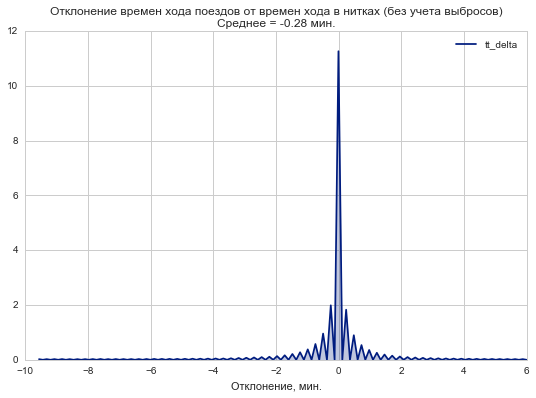

In [17]:
train_plan['tt'] = train_plan.time_end - train_plan.time_start
train_plan['slot_tt'] = train_plan.slot_tt.apply(int)
train_plan['tt_delta'] = train_plan.tt - train_plan.slot_tt
train_plan['tt_delta_abs'] = train_plan.tt_delta.apply(abs)
add_info(links)
links['link_name'] = list(zip(links.st_from_name, links.st_to_name))
train_plan['tt_link'] = train_plan.link_name.map(links.drop_duplicates('link_name').set_index('link_name').time)
df_tt_delta = train_plan[train_plan.slot_tt != -1]
tt_delta_mean = df_tt_delta.tt_delta.mean()
tt_delta_std = df_tt_delta.tt_delta.std()
main = df_tt_delta[df_tt_delta.tt_delta.apply(lambda x: np.abs(x - tt_delta_mean) < 3 * tt_delta_std)]

sns.set(context='notebook', style='whitegrid', palette='dark')
fig = plt.figure()
#ax = sns.distplot(main.tt_delta / 60, hist=False, kde_kws={'shade':True})
ax = sns.kdeplot(main.tt_delta / 60, shade=True)
title = 'Отклонение времен хода поездов от времен хода в нитках (без учета выбросов)\nСреднее = %.2f мин.' \
            % (main.tt_delta.mean() / 60)
ax.set(title=title, xlabel='Отклонение, мин.')
filename = 'main_delta.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Выбросы (большие отклонения времен хода поездов от времен хода в нитках)

In [18]:
max_check_time = datetime.datetime.fromtimestamp(current_time) + datetime.timedelta(1)
#last_dt = df_3h.sort_values('dt_from').iloc[-1].dt_from
df_tt_delta = df_tt_delta[df_tt_delta.dt_3h <= max_check_time]

In [19]:
df_tt_delta['delta_rat'] = df_tt_delta.tt_delta_abs / df_tt_delta.slot_tt

Всего 513 случаев, когда время хода поезда существенно отличается от времени хода в нитке (выбросы).
Частота выбросов по участку и трехчасовому интервалу:
link_name                     dt_3h              
(БЕЛОГОРСК II, ЗАВИТАЯ)       2016-07-15 15:00:00    8
(ПЕТРОВСКИЙ ЗАВОД, ЖИПХЕГЕН)  2016-07-15 12:00:00    8
(БУГАЧ, ЧЕРНОРЕЧЕНСКАЯ)       2016-07-15 18:00:00    8
(МАГДАГАЧИ, УШУМУН)           2016-07-16 12:00:00    8
(КАРЫМСКАЯ, ЧИТА I)           2016-07-16 00:00:00    8
(НАХОДКА, ХМЫЛОВСКИЙ)         2016-07-15 15:00:00    7
(ЖИПХЕГЕН, ПЕТРОВСКИЙ ЗАВОД)  2016-07-16 06:00:00    7
(ЧЕРНОРЕЧЕНСКАЯ, БУГАЧ)       2016-07-15 18:00:00    6
(КАРЫМСКАЯ, ЧИТА I)           2016-07-16 12:00:00    6
(ЗАВИТАЯ, БЕЛОГОРСК II)       2016-07-15 09:00:00    6


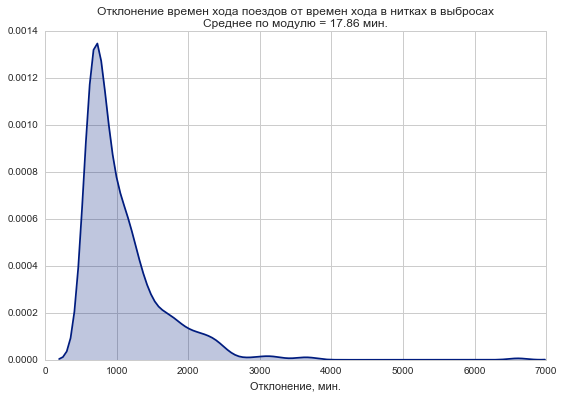

In [20]:
outliers = df_tt_delta[df_tt_delta.tt_delta.apply(lambda x: np.abs(x - tt_delta_mean) > 3 * tt_delta_std)]
cols = ['train', 'st_from_name', 'st_to_name', 'dt_from', 'dt_3h', 'tt', 'slot_tt', 'tt_delta', 'tt_link', 'delta_rat']
add_header('Всего %d случаев, когда время хода поезда существенно отличается от времени хода в нитке (выбросы).' 
          % outliers.train.count())
add_header('Частота выбросов по участку и трехчасовому интервалу:')
add_line(outliers.groupby(['link_name', 'dt_3h']).train.count().sort_values(ascending=False).head(10))

fig = plt.figure()
sns.set(context='notebook', style='whitegrid', palette='dark')
ax = sns.distplot(outliers.tt_delta.apply(abs), hist=False, kde_kws={'shade':True})
title = 'Отклонение времен хода поездов от времен хода в нитках в выбросах\nСреднее по модулю = %.2f мин.' \
            % (outliers.tt_delta_abs.mean() / 60)
ax.set(title=title, xlabel='Отклонение, мин.')
filename = 'outliers_delta.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Подробная статистика по участку, где больше всего выборосов

In [21]:
cols = ['train', 'st_from_name', 'st_to_name', 'time_start', 'dt_from', 'tt', 'slot_tt', 'tt_delta_abs', 'tt_link', 'delta_rat']
l = outliers.groupby(['link_name', 'dt_3h']).train.count().sort_values(ascending=False).reset_index().ix[0].link_name
st_from, st_to = l[0], l[1]
add_header('Статистика по участку с наибольшим количеством выбросов: %s -- %s' % (st_from, st_to), h=3)
add_header('Статистика по ниткам:')
add_line(slot[(slot.st_from_name == st_from) & (slot.st_to_name == st_to)].tt.describe())
add_header('Статистика по выбросам в поездных планах:')
add_line(outliers[(outliers.st_from_name == st_from) & (outliers.st_to_name == st_to)].tt.describe())
add_header('Примеры поездов с временами хода, значительно отличающимися от времен в нитках:')
add_line(outliers[(outliers.st_from_name == st_from) 
                  & (outliers.st_to_name == st_to)].sort_values('tt_delta_abs', ascending=False)[cols].head(10))

Статистика по участку с наибольшим количеством выбросов: БЕЛОГОРСК II -- ЗАВИТАЯ
Статистика по ниткам:
count      135.000000
mean      7649.777778
std       1622.798149
min       7200.000000
25%       7440.000000
50%       7440.000000
75%       7440.000000
max      20820.000000
Статистика по выбросам в поездных планах:
count       8.00000
mean     8199.25000
std       409.51112
min      7658.00000
25%      7872.00000
50%      8205.00000
75%      8431.50000
max      8848.00000
Примеры поездов с временами хода, значительно отличающимися от времен в нитках:
        train  st_from_name st_to_name  time_start             dt_from    tt  slot_tt  tt_delta_abs  tt_link  delta_rat
 210219780858  БЕЛОГОРСК II    ЗАВИТАЯ  1468593900 2016-07-15 17:45:00  7658    10088          2430      720   0.240880
 210219574988  БЕЛОГОРСК II    ЗАВИТАЯ  1468593360 2016-07-15 17:36:00  7800    10088          2288      720   0.226804
 200022043037  БЕЛОГОРСК II    ЗАВИТАЯ  1468593000 2016-07-15 17:30:00  7896   

In [22]:
cols = ['train', 'st_from_name', 'st_to_name', 'dt_from', 'tt', 'slot_tt', 'tt_delta_abs', 'tt_link', 'delta_rat']
add_header('Примеры самых больших (по модулю отклонения) выбросов:', h=3)
add_line(outliers.sort_values('tt_delta_abs', ascending=False)[cols].head(10))

Примеры самых больших (по модулю отклонения) выбросов:
           train st_from_name   st_to_name             dt_from     tt  slot_tt  tt_delta_abs  tt_link  delta_rat
    200022115163    ХРЕБТОВАЯ       ИГИРМА 2016-07-15 17:04:00   6897    13500          6603     4380   0.489111
 999928901012001   РУДНОГОРСК       ИГИРМА 2016-07-16 11:35:00   2646     6360          3714     1500   0.583962
    200022114474    УРУЛЮНГУЙ     МАРГУЦЕК 2016-07-15 14:58:00   1644     5220          3576     1560   0.685057
 999912456012004    ХРЕБТОВАЯ       ИГИРМА 2016-07-16 05:15:12   5861     9120          3259     4380   0.357346
    200020349076      ТАКОВКА       НЕБЕЛЬ 2016-07-16 02:56:58   1507     4620          3113     1380   0.673810
    200021962962    АБАЛАКОВО     СУРИКОВО 2016-07-15 09:00:00  15484    18540          3056     9120   0.164833
 999928931012001     КАРАБУЛА       ЧУНОЯР 2016-07-16 00:40:00  12565    15420          2855     8820   0.185149
    210219496673      КУЛЬДУР  ПЕРЕВАЛЬНЫ

## Проверка входных данных

### Участки планирования без слотов

In [23]:
slot['link_name'] = list(zip(slot.st_from_name, slot.st_to_name))
links['link_name'] = list(zip(links.st_from_name, links.st_to_name))
slot.dropna(subset=['st_from_name', 'st_to_name'], how='any', inplace=True)

In [24]:
slot['tt'] = slot.time_end - slot.time_start
links['slot_tt_init'] = links.link_name.map(slot.groupby('link_name').tt.mean())
links['slot_tt'] = 60 * (links.slot_tt_init // 60)
links[['link_name', 'time', 'slot_tt']]
links_no_slots = links[links.slot_tt.isnull()]
links_no_slots_names = links_no_slots.link_name.unique()
add_header('Всего %d участков планирования без слотов:' % len(links_no_slots_names))
add_line(links_no_slots_names)

Всего 76 участков планирования без слотов:
[('СОЛОВЬЕВСК', 'БОРЗЯ') ('ЕНИСЕЙ', 'ДИВНОГОРСК') ('БЛЮХЕР', 'БАМБУРОВО')
 ('БИРОФЕЛЬД', 'ЛЕНИНСК') ('ОРОСИТЕЛЬНЫЙ', 'ХОНЫХ') ('УГЛОВАЯ', 'УГОЛЬНАЯ')
 ('ХРЕБТОВАЯ', 'КОРШУНИХА-АНГАРСКАЯ')
 ('БЛОКПОСТ 1571 КМ', 'ДАЛЬНЕРЕЧЕНСК I') ('ПЕРЕВАЛ', 'КАЗАНКАН')
 (nan, 'БИРА') ('БИРОФЕЛЬД', nan) ('ПОСТ-ПОКРОВСКИЙ', 'ПОКРОВКА-ПРИСТАНЬ')
 ('КАЗАНКАН', 'ПЕРЕВАЛ') ('ОУНЭ', 'КУЗНЕЦОВСКИЙ') ('ДИВНОГОРСК', 'ЕНИСЕЙ')
 ('СКОВОРОДИНО', 'РЕЙНОВО') (nan, nan) ('КОРШУНИХА-АНГАРСКАЯ', 'ХРЕБТОВАЯ')
 ('СОЛЛУ', 'КУЗНЕЦОВСКИЙ') ('УГОЛЬНАЯ', 'УГЛОВАЯ') ('БАМБУРОВО', 'БЛЮХЕР')
 ('МАХАЛИНО', nan) ('ЭБЕРГАРД', 'ДАЛЬНЕРЕЧЕНСК II') (nan, 'БИРОФЕЛЬД')
 ('БЛОКПОСТ 197 КМ', 'ОУНЭ') ('БАЙКАЛ', 'КУЛТУК') ('ШАРЫПОВО', 'ШУШЬ')
 ('АНГАРСК', 'СУХОВСКАЯ-ЮЖНАЯ') ('ЧЕРЕМХОВО', 'МАКАРЬЕВО')
 ('ПЕРЕВАЛ', 'АНГАРАКАН') ('СОЛЛУ', 'ВЫСОКОГОРНАЯ')
 ('НАХОДКА-ВОСТОЧНАЯ', 'ХМЫЛОВСКИЙ') ('ХМЫЛОВСКИЙ', 'НАХОДКА-ВОСТОЧНАЯ')
 ('БОРЗЯ', 'СОЛОВЬЕВСК') ('ГРОДЕКОВО (КИТАЙ)', 'РАССЫПНАЯ ПАДЬ')
 ('КОРШУНИХА

In [29]:
big_st = stations[stations.norm_time != 0].name.unique()
links_no_big = links_no_slots[(links_no_slots.st_from_name.isin(big_st)) 
                              | (links_no_slots.st_to_name.isin(big_st))].link_name.unique()
add_header('Всего %d участков планирования от крупных станций без слотов:' % len(links_no_big))
add_line(links_no_big)

Всего 14 участков планирования от крупных станций без слотов:
[('СОЛОВЬЕВСК', 'БОРЗЯ') ('ХРЕБТОВАЯ', 'КОРШУНИХА-АНГАРСКАЯ')
 ('СКОВОРОДИНО', 'РЕЙНОВО') ('КОРШУНИХА-АНГАРСКАЯ', 'ХРЕБТОВАЯ')
 ('СОЛЛУ', 'ВЫСОКОГОРНАЯ') ('НАХОДКА-ВОСТОЧНАЯ', 'ХМЫЛОВСКИЙ')
 ('ХМЫЛОВСКИЙ', 'НАХОДКА-ВОСТОЧНАЯ') ('БОРЗЯ', 'СОЛОВЬЕВСК')
 ('КОРШУНИХА-АНГАРСКАЯ', 'ГИДРОСТРОИТЕЛЬ') ('РЕЙНОВО', 'СКОВОРОДИНО')
 ('ВЛАДИВОСТОК', 'ГАЙДАМАК') ('ГАЙДАМАК', 'ВЛАДИВОСТОК')
 ('ВЫСОКОГОРНАЯ', 'БЛОКПОСТ 197 КМ')
 ('ГИДРОСТРОИТЕЛЬ', 'КОРШУНИХА-АНГАРСКАЯ')]


### Выявление участков с неправильным нормативным временем хода

In [309]:
links['delta_tt_perc'] = 100 * np.abs(links.slot_tt - links.time) / links.slot_tt
links['ratio'] = links.slot_tt / links.time
cols = ['link_name', 'time', 'slot_tt', 'ratio']
#links[(links.slot_tt.isnull() == False)][cols].sort_values('delta_tt_perc', ascending=False).head()
links[(links.slot_tt.isnull() == False)][cols].sort_values('ratio', ascending=False).head()

,link_name,time,slot_tt,ratio
251,"(ЗАВИТАЯ, БЕЛОГОРСК II)",540,6840,12.666667
44,"(БЕЛОГОРСК II, ЗАВИТАЯ)",720,7620,10.583333
224,"(КОМСОМОЛЬСК-НА-АМУРЕ II, ЭВОРОН)",1500,14100,9.400000
237,"(ЭВОРОН, КОМСОМОЛЬСК-НА-АМУРЕ II)",1440,13500,9.375000
217,"(ГРОДЕКОВО II, ВОЗДВИЖЕНСКИЙ)",720,6540,9.083333


Всего 23 участков планирования с заниженным или завышенным временем хода относительно ниток: 
[('НАХОДКА', 'ХМЫЛОВСКИЙ') ('БЕЛОГОРСК II', 'ЗАВИТАЯ')
 ('КРУГЛИКОВО', 'ХАБАРОВСК II') ('ВОЗДВИЖЕНСКИЙ', 'ГРОДЕКОВО II')
 ('КОМСОМОЛЬСК-НА-АМУРЕ', 'КОМСОМОЛЬСК-НА-АМУРЕ II') ('БАЗАИХА', 'ЗЛОБИНО')
 ('ВОЛОЧАЕВКА II', 'ТУНГУССКИЙ') ('ГРОДЕКОВО II', 'ВОЗДВИЖЕНСКИЙ')
 ('КОМСОМОЛЬСК-НА-АМУРЕ II', 'ЭВОРОН')
 ('ЭВОРОН', 'КОМСОМОЛЬСК-НА-АМУРЕ II') ('ЗАВИТАЯ', 'БЕЛОГОРСК II')
 ('СЕЛИХИН', 'КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ')
 ('КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ', 'СЕЛИХИН') ('СРЕТЕНСК', 'КУЭНГА')
 ('ХОЛОДНЫЙ КЛЮЧ', 'БУРЕЯ') ('ХАБАРОВСК II', 'КРУГЛИКОВО')
 ('РАССЫПНАЯ ПАДЬ', 'ГРОДЕКОВО')
 ('КОМСОМОЛЬСК-НА-АМУРЕ II', 'КОМСОМОЛЬСК-НА-АМУРЕ')
 ('ИРКУТСК-СОРТИРОВОЧНЫЙ', 'БАТАРЕЙНАЯ') ('ЗЛОБИНО', 'БАЗАИХА')
 ('ТУНГУССКИЙ', 'ВОЛОЧАЕВКА II') ('ХМЫЛОВСКИЙ', 'НАХОДКА')
 ('ГРОДЕКОВО', 'РАССЫПНАЯ ПАДЬ')]
Примеры завышенных нормативов:
                                       link_name  time  slot_tt     ratio
    

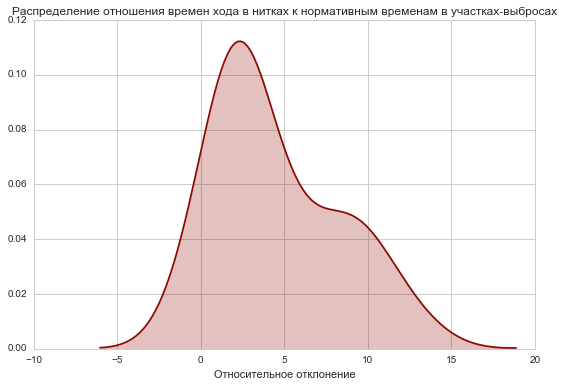

In [310]:
rmean = links.ratio.mean()
rstd = links.ratio.std()
outliers = links[links.ratio.apply(lambda x: np.abs(x - rmean) > rstd)]
add_header('Всего %d участков планирования с заниженным или завышенным временем хода относительно ниток: \n%s' %
          (outliers.link_name.count(), outliers.link_name.unique()))
#sns.distplot(links.ratio, hist=False, color='b', kde_kws={'shade':True})
add_header('Примеры завышенных нормативов:')
add_line(outliers.sort_values('ratio')[cols].head())
add_header('Примеры заниженных нормативов:')
add_line(outliers.sort_values('ratio')[cols].tail())
add_header('Свойства распределения выбросов:')
add_line(outliers.ratio.describe())

fig = plt.figure()
sns.set(context='notebook', style='whitegrid', palette='dark')
ax = sns.distplot(outliers.ratio, hist=False, color='r', kde_kws={'shade':True})
title = 'Распределение отношения времен хода в нитках к нормативным временам в участках-выбросах'
ax.set(title=title, xlabel='Относительное отклонение')
filename = 'outliers_slot_tt_ratio.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [311]:
filename = REPORT_FOLDER + 'slot_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован: report/slot_report_20160714_141607.html
